In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit
import time
import scienceplots

plt.style.use('science')

In [ ]:
from cmath import *

def initial(x, alpha, lambda_):
    return np.sqrt(alpha / np.sqrt(np.pi)) * np.exp(-alpha**2 * (x - lambda_)**2 / 2)

def actual(x, t, alpha, omega, lambda_):
    xi = alpha * x
    xi_lambda = alpha * lambda_
    
    phase = -0.5 * (xi - xi_lambda * np.cos(omega * t))**2
    oscillation = -1j * (0.5 * omega * t + xi * xi_lambda * np.sin(omega * t) - 0.25 * xi_lambda**2 * np.sin(2 * omega * t))
    
    return np.sqrt(alpha / np.sqrt(np.pi)) * np.exp(phase + oscillation)

def V(x, omega):
    return 0.5 * omega**2 * x**2

omega = 0.2
lambda_ = 10
a, b = -40, 40
N = 300
alpha = np.sqrt(omega)
x = np.linspace(a, b, N)
T = 2 * np.pi / omega

timesteps = 3000
t = np.linspace(0, T*10, timesteps)

dt = t[1] - t[0]
dx = (b - a) / (N - 1)
trace = np.zeros((timesteps, N))

for i, t_i in enumerate(t):
    psi_t = actual(x, t_i, alpha, omega, lambda_)
    trace[i] = np.abs(psi_t)


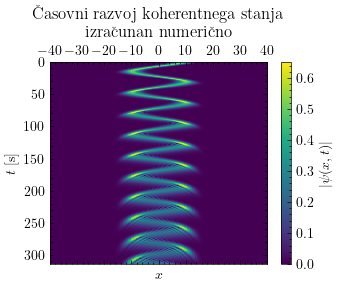

In [ ]:
def gen_a(n, dx, dt, V):
    b = 1j * dt / (2 * dx**2)
    a = -b / 2
    diag1 = np.eye(n, k=1) * a
    diag2 = np.eye(n, k=-1) * a    
    diag3 = np.diag(1 + b + 1j * dt / 2 * V, k=0)
    A = diag1 + diag2 + diag3
    return np.array(A)

x_0 = initial(x, alpha, lambda_)[1:-1]
x_small = x[1:-1]

Vs = V(x, omega)[1:-1]
n = len(x_0)
A = gen_a(n, dx, dt, Vs)

psi_n = x_0
trace2 = np.zeros((timesteps, N))

for i, t_i in enumerate(t):
    psi_n = np.linalg.inv(A) @ np.conjugate(A) @ psi_n
    trace2[i] = np.abs(np.concatenate(([0], psi_n, [0]))) # zmansu in pol paddu trace

fig, ax = plt.subplots()
cax = ax.matshow(trace2, aspect='auto', extent=[a, b, T*10, 0])
cb = fig.colorbar(cax)
cb.set_label('$|\\psi(x, t)|$')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$ [s]')
plt.title('Časovni razvoj koherentnega stanja \n izračunan numerično')
plt.show()

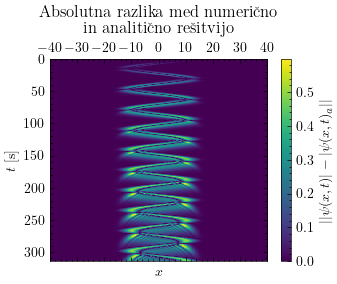

In [ ]:
fig, ax = plt.subplots()
cax = ax.matshow(np.abs(trace2 - trace), aspect='auto', extent=[a, b, T*10, 0])
cb = fig.colorbar(cax)
cb.set_label('$| |\\psi(x, t)| - |\\psi(x, t)_a| |$')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$ [s]')
plt.title('Absolutna razlika med numerično \n in analitično rešitvijo')
plt.show()

In [31]:
omega = 0.2
lambda_ = 10
a, b = -40, 40
N = 300
alpha = np.sqrt(omega)
x = np.linspace(a, b, N)
T = 2 * np.pi / omega

timesteps = 300
t = np.linspace(0, T, timesteps)

dt = t[1] - t[0]
dx = (b - a) / (N - 1)
trace = np.zeros((timesteps, N))

for i, t_i in enumerate(t):
    psi_t = actual(x, t_i, alpha, omega, lambda_)
    trace[i] = np.abs(psi_t)


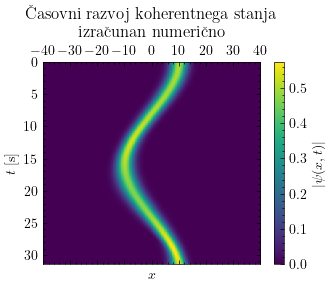

In [ ]:
x_0 = initial(x, alpha, lambda_)[1:-1]
x_small = x[1:-1]

Vs = V(x, omega)[1:-1]
n = len(x_0)
A = gen_a(n, dx, dt, Vs)

psi_n = x_0
trace2 = np.zeros((timesteps, N))

for i, t_i in enumerate(t):
    psi_n = np.linalg.inv(A) @ np.conjugate(A) @ psi_n
    trace2[i] = np.abs(np.concatenate(([0], psi_n, [0]))) # zmansu in pol paddu trace

fig, ax = plt.subplots()
cax = ax.matshow(trace2, aspect='auto', extent=[a, b, T, 0])
cb = fig.colorbar(cax)
cb.set_label('$|\\psi(x, t)|$')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$ [s]')
plt.title('Časovni razvoj koherentnega stanja \n izračunan numerično')
plt.show()

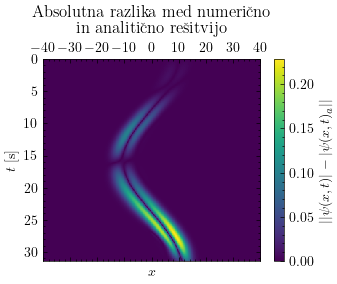

In [ ]:
fig, ax = plt.subplots()
cax = ax.matshow(np.abs(trace2 - trace), aspect='auto', extent=[a, b, T, 0])
cb = fig.colorbar(cax)
cb.set_label('$| |\\psi(x, t)| - |\\psi(x, t)_a| |$')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$ [s]')
plt.title('Absolutna razlika med numerično \n in analitično rešitvijo')
plt.show()

In [35]:
import tracemalloc

omega = 0.2
lambda_ = 10
a, b = -40, 40

data = {
}

for N in range(100, 501, 100):
    alpha = np.sqrt(omega)
    x = np.linspace(a, b, N)
    T = 2 * np.pi / omega
    timesteps = N
    t = np.linspace(0, T, timesteps)
    dt = t[1] - t[0]
    dx = (b - a) / (N - 1)

    trace = np.zeros((timesteps, N))

    for i, t_i in enumerate(t):
        psi_t = actual(x, t_i, alpha, omega, lambda_)
        trace[i] = np.abs(psi_t)

    x_0 = initial(x, alpha, lambda_)[1:-1]
    x_small = x[1:-1]

    Vs = V(x, omega)[1:-1]
    n = len(x_0)
    A = gen_a(n, dx, dt, Vs)

    psi_n = x_0
    trace2 = np.zeros((timesteps, N))

    # measure time and memory
    tracemalloc.start()
    start = time.time()
    for i, t_i in enumerate(t):
        psi_n = np.linalg.inv(A) @ np.conjugate(A) @ psi_n
        trace2[i] = np.abs(np.concatenate(([0], psi_n, [0])))**2
    end = time.time()
    _, memory_usage = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    data[N] = {
        'time': end - start,
        'memory': memory_usage,
        'analityc': trace,
        'numeric': trace2
    }

<>:17: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:34: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:17: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:34: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
/tmp/ipykernel_12619/152111493.py:17: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
  plt.ylabel('Max $ |\psi(x, t)| - |\psi(x, t)_a| |$')
/tmp/ipykernel_12619/152111493.py:34: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mea

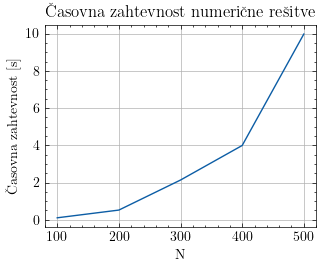

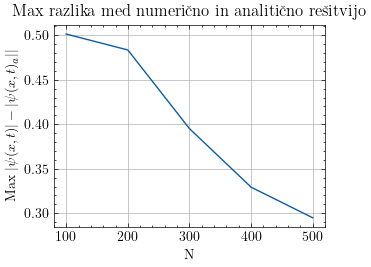

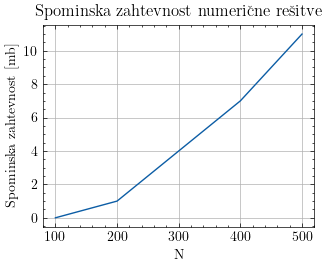

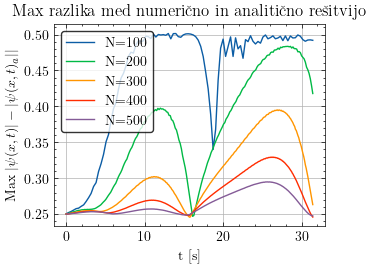

In [ ]:

N = list(data.keys())
N = sorted(N)
computation_time = [data[n]['time'] for n in N]

plt.plot(N, computation_time)
plt.grid()
plt.xlabel('N')
plt.ylabel('Časovna zahtevnost [s]')
plt.title('Časovna zahtevnost numerične rešitve')
plt.show()

max_diff = [np.max(np.abs(data[n]['analityc'] - data[n]['numeric'])) for n in N]

plt.plot(N, max_diff)
plt.grid()
plt.xlabel('N')
plt.ylabel('Max $ |\\psi(x, t)| - |\\psi(x, t)_a| |$')
plt.title('Max razlika med numerično in analitično rešitvijo')
plt.show()

computation_memory = [data[n]['memory']//1024//1024 for n in N]

plt.plot(N, computation_memory)
plt.grid()
plt.xlabel('N')
plt.ylabel('Spominska zahtevnost [mb]')
plt.title('Spominska zahtevnost numerične rešitve')
plt.show()

for n in N:
    t = np.linspace(0, T, n)
    plt.plot(t, np.max(np.abs(data[n]['analityc'] - data[n]['numeric']), axis=1), label=f'N={n}')
plt.xlabel('t [s]')
plt.ylabel('Max $ |\\psi(x, t)| - |\\psi(x, t)_a| |$')
plt.grid()
plt.legend(
    facecolor='white',    # background color
    edgecolor='black',    # border color
    framealpha=0.8,       # transparency (1 is opaque)
    frameon=True          # ensure the frame is drawn
)
plt.title('Max razlika med numerično in analitično rešitvijo')
plt.show()



In [43]:
def initial(x, sigma_0, k0, lambda_):
    return (2 * np.pi * sigma_0**2)**(-0.25) * np.exp(1j * k0 * (x - lambda_)) * np.exp(-((x - lambda_)**2) / (4 * sigma_0**2))

def actual(x, t, sigma_0, k0, lambda_):
    sigma_t =  np.sqrt(1 + 1j * t / (2 * sigma_0**2))
    phase = 1j * k0**2 * t / 2
    gaussian_envelope = -(x - lambda_)**2 / (4 * sigma_0**2)
    return (2 * np.pi * sigma_0**2)**(-0.25) / sigma_t * np.exp(
        (gaussian_envelope + 1j * k0 * (x - lambda_) - phase) / (1 + 1j * t / (2 * sigma_0**2))
    )

sigma_0 = 1 / 20
k0 = 50 * np.pi
lambda_ = 0.25
a, b = -0.5, 1.5
N = 1000
x = np.linspace(a, b, N)

dx = (b - a) / (N - 1)
dt = 2 * dx**2
t = np.arange(0, 500) * dt

trace = np.zeros((len(t), N))
for i, t_i in enumerate(t):
    psi_t = actual(x, t_i, sigma_0, k0, lambda_)
    trace[i] = np.abs(psi_t)

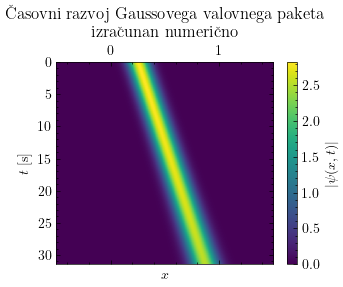

In [44]:
def gen_a(n, dx, dt):
    b = 1j * dt / (2 * dx**2)
    a = -b / 2
    diag1 = np.eye(n, k=1) * a
    diag2 = np.eye(n, k=-1) * a    
    diag3 = np.eye(n, k=0) * (1 + b)
    A = diag1 + diag2 + diag3
    return np.array(A)

x_0 = initial(x, sigma_0, k0, lambda_)[1:-1]
x_small = x[1:-1]

n = len(x_0)
A = gen_a(n, dx, dt)

psi_n = x_0
trace2 = np.zeros((len(t), N))

for i, t_i in enumerate(t):
    psi_n = np.linalg.inv(A) @ np.conjugate(A) @ psi_n
    trace2[i] = np.abs(np.concatenate(([0], psi_n, [0])))

fig, ax = plt.subplots()
cax = ax.matshow(trace2, aspect='auto', extent=[a, b, T, 0])
cb = fig.colorbar(cax)
cb.set_label('$|\\psi(x, t)|$')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$ [s]')
plt.title('Časovni razvoj Gaussovega valovnega paketa \n izračunan numerično')
plt.show()



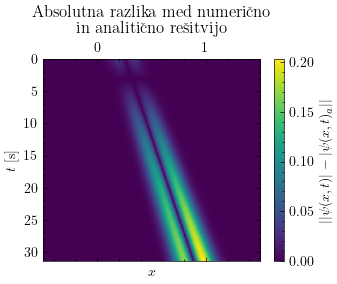

In [45]:
fig, ax = plt.subplots()
cax = ax.matshow(np.abs(trace2 - trace), aspect='auto', extent=[a, b, T, 0])
cb = fig.colorbar(cax)
cb.set_label('$| |\\psi(x, t)| - |\\psi(x, t)_a| |$')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$ [s]')
plt.title('Absolutna razlika med numerično \n in analitično rešitvijo')
plt.show()